In [1]:
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import argparse
import pdb
import matplotlib.pyplot as plt
from drawnow import drawnow, figure
import torch.utils.data as data_utils
from itertools import islice
import pickle

torch.cuda.is_available()

/usr/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [11]:
def showImageGrid(images, nrows, ncols, h, w, figsize):
    # create figure (fig), and array of axes (ax)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for i, (image, axi) in enumerate(zip(images[:nrows*ncols],ax.flat)):
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        axi.imshow(image.reshape(h,w))
        axi.set_axis_off()
        # get indices of row/column
        rowid = i // ncols
        colid = i % ncols
        # write row/col indices as axes' title for identification
        axi.set_title("Image " + str(i))
    plt.show()

In [5]:
def get_loaders(loader_batchsize):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data', 
            train=True, 
            download=True,
            transform=transforms.Compose(
                [
                    transforms.ToTensor(),
                    #transforms.Normalize((0,), (1,))
                ]
           )
        ),
        batch_size=loader_batchsize, 
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            '../data', 
            train=False, 
            transform=transforms.Compose(
                [
                    transforms.ToTensor(),
                    #transforms.Normalize((7,), (0.3081,))
                ]
            )
        ),
        batch_size=loader_batchsize, 
        shuffle=True
    )

    return train_loader, test_loader

In [59]:
# reset the dataset loaders
train_loader, test_loader = get_loaders(1000)

In [29]:
#validate the shape of the data
images, labels = next(iter(train_loader))
print("Shape of images tensor: {}".format(images.shape))
print("Shape of labels tensor: {}".format(labels.shape))

Shape of images tensor: torch.Size([1000, 1, 28, 28])
Shape of labels tensor: torch.Size([1000])


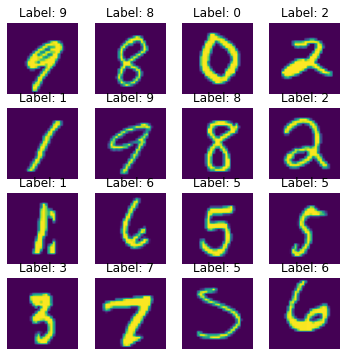

In [86]:
#validate that the label corresponds to a image
# settings
h, w = 28, 28        # for raster image
nrows, ncols = 4, 4  # array of sub-plots
figsize = [6, 6]     # figure size, inches
# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

il = list(zip(images,labels))[:nrows*ncols]
for i, ((image, label), axi) in enumerate(zip(il,ax.flat)):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    axi.imshow(image.reshape(h,w))
    axi.set_axis_off()
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    axi.set_title("Label: " + str(label.item()))
plt.show()

In [6]:
def mixDigits(digit1, digit2, loader, L1, batchsize): 
    dataset1, dataset2 = [], []
    for i, (ft, tar) in enumerate(loader):   
        # selects all images of digit 1
        mask = torch.eq(tar, digit1)
        inds = torch.nonzero(mask).squeeze()
        ft1 = torch.index_select(ft, dim=0, index=inds)
        dataset1.append(ft1)

        # selects all images of digit 2
        mask = torch.eq(tar, digit2)
        inds = torch.nonzero(mask).squeeze()
        ft2 = torch.index_select(ft, dim=0, index=inds)
        dataset2.append(ft2)
        
    dataset1 = torch.cat(dataset1, dim=0)
    dataset2 = torch.cat(dataset2, dim=0)
    n1 = torch.randn(dataset1.size(0), L1) 
    n2 = torch.randn(dataset2.size(0), L1) 
    N1, N2 = dataset1.size(0), dataset2.size(0)
    Nmix = min([N1, N2])
    dataset_mix = dataset1[:Nmix] + dataset2[:Nmix]

    n1 = data_utils.TensorDataset(n1)
    n2 = data_utils.TensorDataset(n2)    
    dataset1 = data_utils.TensorDataset(dataset1)
    dataset2 = data_utils.TensorDataset(dataset2)
    dataset_mix = data_utils.TensorDataset(dataset_mix)
    
    noise1 = data_utils.DataLoader(n1, batch_size=batchsize, shuffle=False)
    noise2 = data_utils.DataLoader(n2, batch_size=batchsize, shuffle=False)
    loader1 = data_utils.DataLoader(dataset1, batch_size=batchsize, shuffle=False)
    loader2 = data_utils.DataLoader(dataset2, batch_size=batchsize, shuffle=False)
    loader_mix = data_utils.DataLoader(dataset_mix, batch_size=batchsize, shuffle=False)

    return noise1, noise2, loader1, loader2, loader_mix

In [108]:
#reload the mixed dataset
_,_,loader1, loader2, loader_mix = mixDigits(1,0,train_loader, 200, 1000)

In [109]:
#validate the shape
[imagesMixed] = next(iter(loader_mix))
[images1] = next(iter(loader1))
[images2] = next(iter(loader2))
print("Shape of images1 tensor: {}".format(images1.shape))
print("Shape of images2 tensor: {}".format(images2.shape))
print("Shape of imagesMixed tensor: {}".format(imagesMixed.shape))

Shape of images1 tensor: torch.Size([1000, 1, 28, 28])
Shape of images2 tensor: torch.Size([1000, 1, 28, 28])
Shape of imagesMixed tensor: torch.Size([1000, 1, 28, 28])


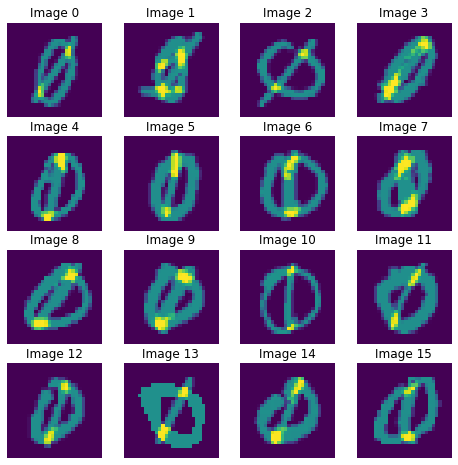

In [211]:
#validate the mixed images
showImageGrid(imagesMixed, 4, 4, 28, 28, [8,8])

In [50]:
#define the models
class DebugLayer(nn.Module):
    def __init__(self, log):
        super(DebugLayer, self).__init__()
        self.log = log
    
    def forward(self, x):
        print(self.log)
        print(x.shape)
        return x
    
class Conv2dAdapter(nn.Module):
    def __init__(self, outputSize, isIn):
        super(Conv2dAdapter, self).__init__()
        self.outputSize = outputSize
        self.isIn = isIn
    
    def forward(self, x):
        if self.isIn:
            s = int(np.sqrt(self.outputSize))
            out = x.view(-1, 1, s, s)
        else:
            out = x.view(-1, self.outputSize)
        return out

class netG_images(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(netG_images, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        
        self.mainModule = nn.Sequential(
            #DebugLayer("gen input"),
            nn.Linear(self.inputSize, self.hiddenSize, bias=True),
            #DebugLayer("gen first lin"),
            nn.Softplus(),
            #DebugLayer("gen first sf"),
            nn.Linear(self.hiddenSize, self.outputSize, bias=True),
            #DebugLayer("gen second lin"),
            nn.Softplus(),
            #DebugLayer("gen second sf"),
            Conv2dAdapter(self.outputSize, True),
            #DebugLayer("conv adapter in"),
            nn.Conv2d(in_channels=1,out_channels=1,kernel_size=5,
                     padding=2),
            #DebugLayer("gen conv")
            Conv2dAdapter(self.outputSize, False),
            #DebugLayer("conv adapter out"),
            nn.Softplus(),
            #DebugLayer("gen third sf")
        )
        
    def forward(self, x):
        return self.mainModule(x.view(-1,self.inputSize))


class netD_images(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(netD_images, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize

        self.mainModule = nn.Sequential(
            #DebugLayer("disc input"),
            nn.Linear(self.inputSize, self.hiddenSize, bias=True),
            #DebugLayer("disc first lin"),
            nn.Tanh(),
            #DebugLayer("disc tanh"),
            nn.Linear(self.hiddenSize, 1, bias=True),
            #DebugLayer("disc second lin"),
        )
        
    def forward(self, x):
        return self.mainModule(x.view(-1,self.inputSize))


In [40]:
def adversarial_trainer( 
    train_loader, 
    noise_loader,
    generator, 
    discriminator, 
    epochs=5,
    learningRate=0.001,
    criterion=nn.BCELoss(),
    clampLower=-0.01,
    clampHigher=0.01,
    Diters=5,
    Giters=1
):
    inputSize, outputSize = generator.inputSize, generator.outputSize
    
    optimizerD = optim.RMSprop(discriminator.parameters(), lr=learningRate)
    optimizerG = optim.RMSprop(generator.parameters(), lr=learningRate)
    
    my_dpi = 96
    plt.figure(figsize=(1200/my_dpi, 600/my_dpi), dpi=my_dpi)
    true, false = 1, 0
    one = torch.tensor(1, dtype=torch.float)
    mone = one * -1
    
    dRealErr = []
    dFakeErr = []
    gErr = []
    
    for epoch in range(epochs):
        for batch, ([ft], [noise]) in enumerate(zip(train_loader, noise_loader)):
            ft = ft.squeeze()

            for disc_ep in range(Diters):
                for p in discriminator.parameters():
                    p.data.clamp_(clampLower, 
                                  clampHigher)


                # discriminator gradient with real data
                discriminator.zero_grad()
                out_d = discriminator.forward(ft)

                err_D_real = out_d.mean()
                err_D_real.backward(one)

                # discriminator gradient with generated data
                
                out_g = generator.forward(noise)
                out_d_g = discriminator.forward(Variable(out_g.data))
                err_D_fake = out_d_g.mean()
                err_D_fake.backward(mone)

                err_D = err_D_real - err_D_fake
                optimizerD.step()

            # generator gradient
            for gEpoch in range(Giters):
                generator.zero_grad()
                out_h_data = discriminator.forward(ft)    
                out_h_g = discriminator.forward(out_g) 
                #err_G = ((out_h_data.mean(0) - out_h_g.mean(0))**2).sum()
                err_G = torch.mean(out_h_g)
                err_G.backward()

                optimizerG.step()

        # show the current generated output
        dRealErr
        dFakeErr
        gErr
        if (epoch + 1) % 10 == 0:
            showImageGrid(out_g.detach().numpy(), 2, 2, 28, 28, [4,4])
            print("out_d {}".format(out_d.mean()))
            print("out_d_g {}".format(out_d_g.mean()))
            print("err_G {}".format(err_G.mean()))
            print("Epoch {}".format(epoch))

In [22]:
batchSize = 1000
train_loader, test_loader = get_loaders(batchSize)
noise1, noise2, loader1, loader2, loader_mix = mixDigits(1,0,train_loader, 200, batchSize)



In [ ]:
gen1 = netG_images(inputSize=200, hiddenSize=50, outputSize=28*28)
disc1 = netD_images(inputSize=28*28, hiddenSize=50)
gen2 = netG_images(inputSize=200, hiddenSize=50, outputSize=28*28)
disc2 = netD_images(inputSize=28*28, hiddenSize=50)

adversarial_trainer( 
    train_loader=loader1, 
    noise_loader=noise1,
    generator=gen1, 
    discriminator=disc1, 
    epochs=100,
    learningRate=0.001,
    criterion=nn.BCELoss()
)

adversarial_trainer( 
    train_loader=loader2, 
    noise_loader=noise2,
    generator=gen2, 
    discriminator=disc2, 
    epochs=100,
    learningRate=0.001,
    criterion=nn.BCELoss()
)

In [32]:
def maxlikelihood_separatesources(
    generators,
    loader_mix, 
    epochs=5
):
    generator1, generator2 = generators
    inputSize, outputSize = generator1.inputSize, generator1.outputSize
    
    x1hat, x2hat = [], []
    mixes = []
    for i, [mix] in enumerate(loader_mix): 
        mix1 = mix
        mix = mix.squeeze().view(-1,28*28)
        print('Processing source ',i)
        Nmix = mix.size(0)
        x1 = Variable(torch.rand(Nmix, inputSize), requires_grad=True)
        x2 = Variable(torch.rand(Nmix, inputSize), requires_grad=True)

        optimizer_sourcesep = optim.Adam([x1, x2], lr=1e-3, betas=(0.5, 0.999))
        for epoch in range(epochs):
           
            mix_sum = generator1.forward(x1) + generator2.forward(x2) 
            #Poisson
            eps = 1e-20
            err = torch.mean(-Variable(mix)*torch.log(mix_sum+eps) + mix_sum)

            err.backward()

            optimizer_sourcesep.step()

            x1.grad.data.zero_()
            x2.grad.data.zero_()

            #print('Step in epoch [{:d}\{:d}]'.format(epoch+1, epochs))
            #print('The error is ', err)
        x1hat.append(generator1.forward(x1).data.cpu().numpy())
        x2hat.append(generator2.forward(x2).data.cpu().numpy())
        mixes.append(mix1.cpu().numpy())

    print('sum is:', x1hat[0].sum())
    num_ims, c = 30, 2
    figure(num=None, figsize=(3*c, num_ims*c), dpi=80, facecolor='w', edgecolor='k')
    sqrtL2 = 28
    for i in range(num_ims):
        plt.subplot(num_ims, 3, 3*i + 1)
        plt.imshow(x1hat[0][i].reshape(sqrtL2, sqrtL2))
        plt.title('Estimated Source 1')

        plt.subplot(num_ims, 3, 3*i + 2)
        plt.imshow(x2hat[0][i].reshape(sqrtL2, sqrtL2))
        plt.title('Estimated Source 2')

        plt.subplot(num_ims, 3, 3*i + 3)
        plt.imshow(mixes[0][i].reshape(sqrtL2, sqrtL2))
        plt.title('Mixture')

Processing source  0
Processing source  1
Processing source  2
Processing source  3
Processing source  4
Processing source  5
sum is: 54490.336


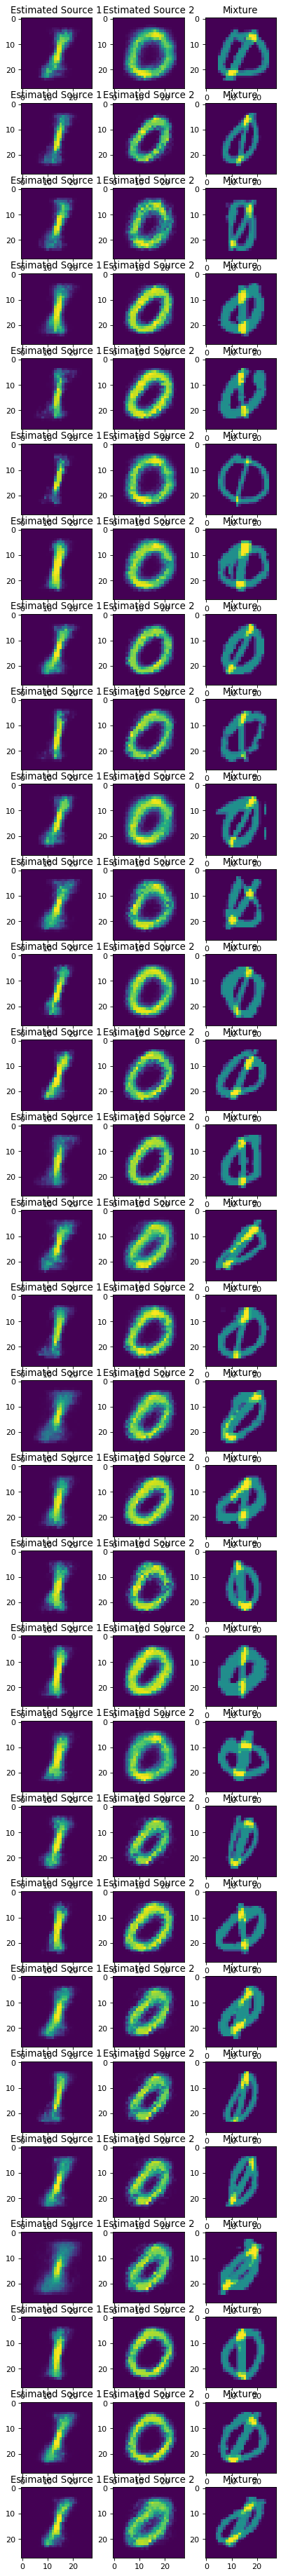

In [52]:
maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=loader_mix,
    epochs=2000
)